# GD8. GO/STOP! - Object Detection 시스템 만들기 - 테슬라 FSD(Full Self Driving)를 위한 오브젝트 검출 따라하기
### 해당 노드는 누군가의 깃허브를 참고하여 만들어졌으며, 100% 제가 만든 코드가 아닙니다.
### 내용이 너무 흥미로워 코드 리뷰 형식으로 업로드 했음을 밝힙니다.

## 1. 자율주행 시스템 만들기


위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만들어 주세요.

-   입력으로 이미지 경로를 받습니다.
-   정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.
-   조건은 다음과 같습니다.
    -   사람이 한 명 이상 있는 경우
    -   차량의 크기(width or height)가 300px이상인 경우

![](https://github.com/ParkJongham/ham/blob/master/AIFFEL/GOING%20DEEPER/GOING%20DEEPER_06/img/%EC%9E%90%EC%9C%A8%EC%A3%BC%ED%96%89%20%EC%8B%9C%EC%8A%A4%ED%85%9C%20%EB%A7%8C%EB%93%A4%EA%B8%B0.png?raw=true)
<br></br>

## 2. 자율주행 시스템 평가하기

아래 `test_system()` 를 통해서 위에서 만든 함수를 평가해봅시다. 10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해줍니다.

![](https://github.com/ParkJongham/ham/blob/master/AIFFEL/GOING%20DEEPER/GOING%20DEEPER_06/img/%EC%9E%90%EC%9C%A8%EC%A3%BC%ED%96%89%20%EC%8B%9C%EC%8A%A4%ED%85%9C%20%ED%8F%89%EA%B0%80%ED%95%98%EA%B8%B0.png?raw=true)
---

## 1. 자율주행 시스템 만들기

In [2]:
# 라이브러리 임포트

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

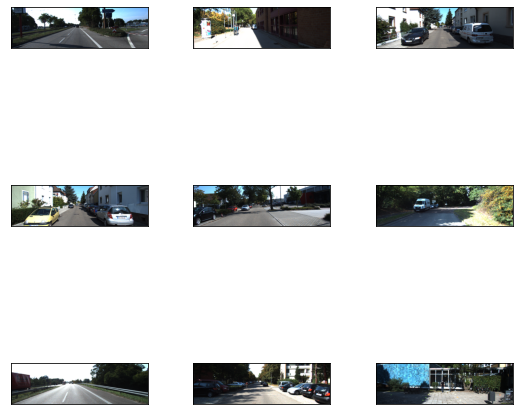

In [4]:
# 데이터셋 살펴보기

fig = tfds.show_examples(ds_train, ds_info)

In [5]:
# 데이터셋 정보 확인

ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/home/aiffel/tensorflow_datasets/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
         

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 1.86, -1.58, -1.64], dtype=float32)>, 'bbox': <tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0.20898667, 0.20362319, 0.5363467 , 0.3614815 ],
       [0.40906668, 0.53471017, 0.52088   , 0.56575686],
       [0.4476    , 0.5137037 , 0.50096   , 0.5338406 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1.5 , 1.62, 4.19],
       [1.63, 1.48, 2.37],
       [1.41, 1.58, 4.36]], dtype=float32)>, 'location': <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[-3.73,  1.55, 11.04],
       [ 2.93,  1.91, 29.37],
       [ 3.03,  2.53, 55.02]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([0, 0, 1])>, 'rotation_y': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 1.54, -1.49, -1.59], dtype=float32)>, 'truncated': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0

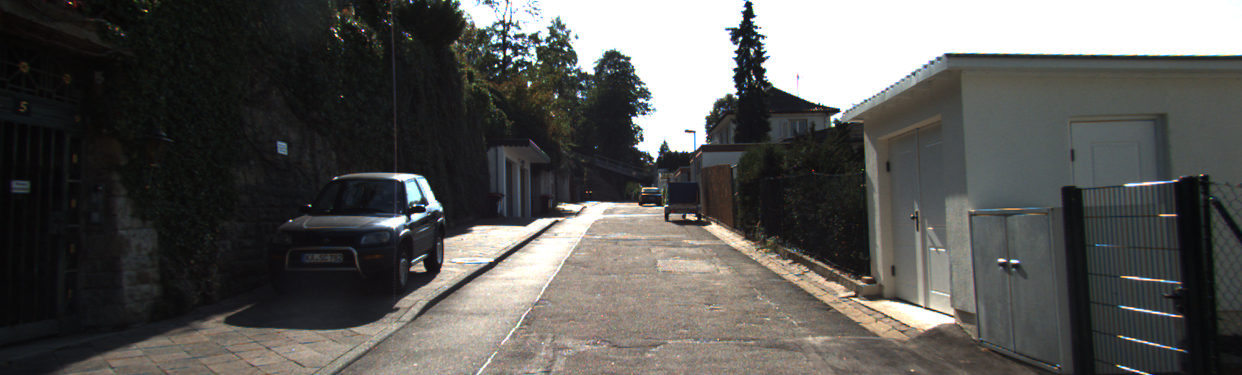

In [6]:
# 학습 데이터 확인

TakeDataset = ds_train.take(1)

for example in TakeDataset:  
    print('------Example------')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

width: 1242  height: 375
(3, 4)
[252.90001 296.63    448.96002 173.87   ]
[664.11005 221.59999 702.67004 179.67001]
[638.02 207.15 663.03 187.14]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F9FBC583710>


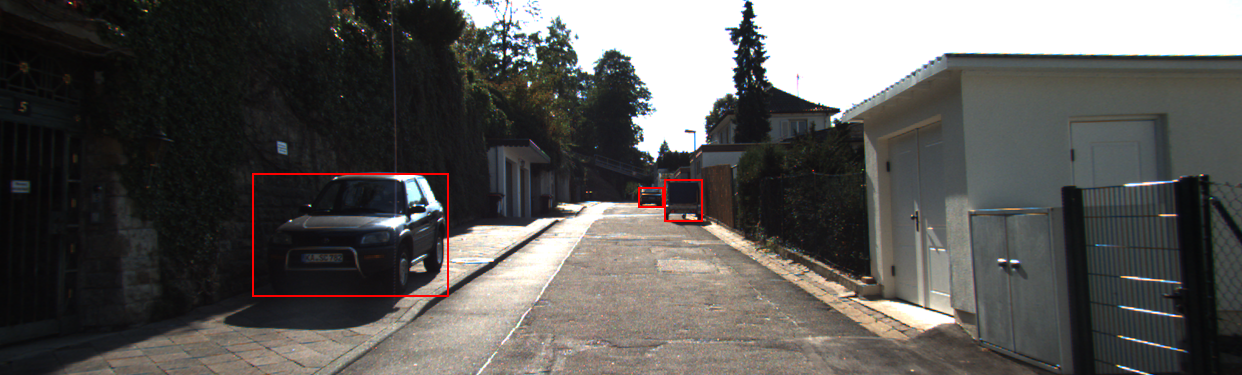

In [7]:
# 바운딩 박스 구현

# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

In [8]:
# 학습용 데이터셋 포맷

import os
data_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
img_dir = os.getenv('HOME')+'/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)

        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size

        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height

        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            break
    return df

df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

100%|██████████| 6347/6347 [12:52<00:00,  8.22it/s]


In [9]:
# 테스트 데이터셋 포맷

test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

100%|██████████| 711/711 [01:31<00:00,  7.75it/s]


In [10]:
# 클래스 맵핑

class_txt_path = data_dir + '/classes.txt'

def save_class_format(path="./classes.txt"):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

save_class_format(class_txt_path)

In [11]:
# 모델 훈련

# RetinaNet 훈련이 시작됩니다!! 50epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv data/kitti_train.csv data/classes.txt

2021-04-29 17:01:15.506878: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-29 17:01:17.263476: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-04-29 17:01:17.276084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-29 17:01:17.276757: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.44GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2021-04-29 17:01:17.276801: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-29 17:01:17.281125: I tensorflow/stream_executor/platform/

Epoch 1/50
2021-04-29 17:01:27.929666: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2021-04-29 17:01:29.685900: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned 256
2021-04-29 17:01:29.731207: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-04-29 17:01:30.112738: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-04-29 17:01:53.709384: W tensorflow/core/common_runtime/bfc_allocator.cc:246] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
195/


Epoch 00015: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
195/195 [==============================] - 68s 350ms/step - loss: 1.5118 - regression_loss: 1.1678 - classification_loss: 0.3441
Epoch 16/50
195/195 [==============================] - ETA: 0s - loss: 1.2439 - regression_loss: 0.9550 - classification_loss: 0.2889
Epoch 00016: saving model to ./snapshots/resnet50_csv_16.h5
195/195 [==============================] - 68s 350ms/step - loss: 1.2439 - regression_loss: 0.9550 - classification_loss: 0.2889
Epoch 17/50
195/195 [==============================] - ETA: 0s - loss: 1.2054 - regression_loss: 0.9215 - classification_loss: 0.2839
Epoch 00017: saving model to ./snapshots/resnet50_csv_17.h5
195/195 [==============================] - 68s 350ms/step - loss: 1.2054 - regression_loss: 0.9215 - classification_loss: 0.2839
Epoch 18/50
195/195 [==============================] - ETA: 0s - loss: 1.2314 - regression_loss: 0.9435 - classification_loss: 0.2879
Epoch 0001

195/195 [==============================] - ETA: 0s - loss: 1.0411 - regression_loss: 0.7794 - classification_loss: 0.2617
Epoch 00032: saving model to ./snapshots/resnet50_csv_32.h5

Epoch 00032: ReduceLROnPlateau reducing learning rate to 9.999999717180686e-11.
195/195 [==============================] - 69s 352ms/step - loss: 1.0411 - regression_loss: 0.7794 - classification_loss: 0.2617
Epoch 33/50
195/195 [==============================] - ETA: 0s - loss: 1.0129 - regression_loss: 0.7691 - classification_loss: 0.2439
Epoch 00033: saving model to ./snapshots/resnet50_csv_33.h5
195/195 [==============================] - 68s 349ms/step - loss: 1.0129 - regression_loss: 0.7691 - classification_loss: 0.2439
Epoch 34/50
195/195 [==============================] - ETA: 0s - loss: 1.0956 - regression_loss: 0.8337 - classification_loss: 0.2618
Epoch 00034: saving model to ./snapshots/resnet50_csv_34.h5
195/195 [==============================] - 68s 349ms/step - loss: 1.0956 - regression_loss:

195/195 [==============================] - ETA: 0s - loss: 1.1042 - regression_loss: 0.8401 - classification_loss: 0.2641
Epoch 00047: saving model to ./snapshots/resnet50_csv_47.h5

Epoch 00047: ReduceLROnPlateau reducing learning rate to 9.999998845134856e-18.
195/195 [==============================] - 68s 349ms/step - loss: 1.1042 - regression_loss: 0.8401 - classification_loss: 0.2641
Epoch 48/50
195/195 [==============================] - ETA: 0s - loss: 1.0859 - regression_loss: 0.8272 - classification_loss: 0.2587
Epoch 00048: saving model to ./snapshots/resnet50_csv_48.h5
195/195 [==============================] - 68s 349ms/step - loss: 1.0859 - regression_loss: 0.8272 - classification_loss: 0.2587
Epoch 49/50
195/195 [==============================] - ETA: 0s - loss: 1.0020 - regression_loss: 0.7582 - classification_loss: 0.2438
Epoch 00049: saving model to ./snapshots/resnet50_csv_49.h5
195/195 [==============================] - 68s 349ms/step - loss: 1.0020 - regression_loss:

In [12]:
# 케라스 모델로 변환

!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_50.h5 snapshots/resnet50_csv_50_infer.h5

2021-04-29 17:59:11.181739: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-29 17:59:12.963489: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-04-29 17:59:12.995170: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-29 17:59:12.995647: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.44GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2021-04-29 17:59:12.995677: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-29 17:59:13.000057: I tensorflow/stream_executor/platform/

In [13]:
# 변환 모델 load

%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

model_path = os.getenv('HOME') + '/aiffel/object_detection/snapshots/resnet50_csv_50_infer.h5'
model = load_model(model_path, backbone_name='resnet50')

Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


[592.729   175.09222 625.91376 205.98816]
[190.14842 128.2471  373.4932  230.09882]


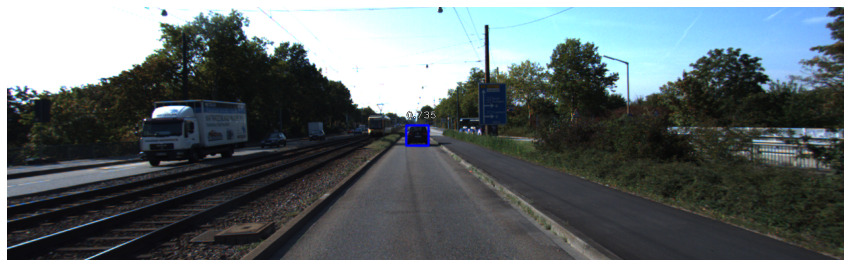

In [14]:
# 추론 및 시각화

import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path="./test_set/go_1.png", visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

inference_on_image(model, img_path=img_path)

[773.97754 149.76993 844.505   317.99515]
[770.29675 178.95834 869.4674  281.87244]


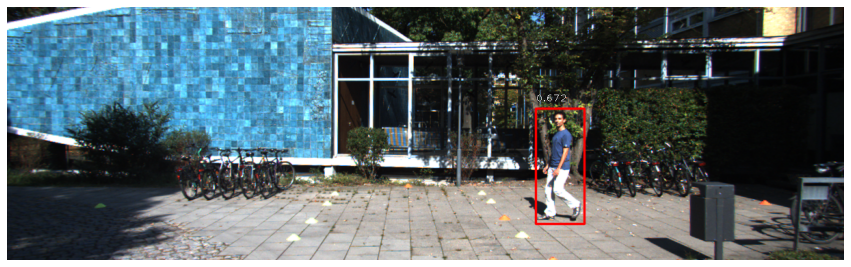

In [15]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path=img_path)

In [17]:
img_path = os.getenv('HOME') + '/aiffel/object_detection/test_set/stop_1.png'

def self_drive_assist(img_path, size_limit = 300) : 
    image = read_image_bgr(img_path)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

   
        
    # 사람이 한 명 이상 있는 경우, 차량의 크기(width or height)가 300px이상인 경우 Stop
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        print(box)
        if score < 0.5:
            break
                
        if label == 1 :
            return 'Stop'
            
        elif box[2] - box[0] >= size_limit or box[3] - box[1] >= size_limit : 
            return 'Stop'
          
    return 'Go'
        

print(self_drive_assist(img_path))

[773.97754 149.76993 844.505   317.99515]
Stop


## 2. 자율주행 시스템 평가하기

In [18]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

[773.97754 149.76993 844.505   317.99515]
[419.64688 163.05647 497.29242 332.48114]
[  0.      201.32523 317.6334  368.76883]
[ 749.8146     31.419344 1098.9213    356.57593 ]
[ 886.3562   178.52106 1241.0684   369.94104]
[592.729   175.09222 625.91376 205.98816]
[190.14842 128.2471  373.4932  230.09882]
[627.1352  172.15427 665.81165 211.92326]
[635.0818  175.11702 680.8908  207.68939]
[808.11835 149.97685 882.6776  182.78572]
[694.71375 172.3762  789.28143 248.73027]
[ 10.782743 190.85818  217.9086   304.19492 ]
100점입니다.


# 회고

## 1. 테슬라에서 자율주행을 위한 프로그램이 어떻게 작동되는지 조금이나마 엿볼 수 있었다.
    - 이미지를 가로로 긴 와이드로 불러들여 실제로 자동차가 보는 시각으로 표현한게 주 특징이다.

## 2. 1차 세팅에선 에포크를 50으로 설정하고 2시간 정도 걸려 나온 결과들인데, 2차로 에포크를 100으로 설정하고 다시 돌려봐야겠다.

## 3. AI와 CV를 오고 싶었던 주된 이유가 자율주행 차량 모델을 만들어 보고 싶어서 였는데, 직접 만들어보니 작업 속도와 흥미가 급발진 하듯이 진행되어 결과에 뿌듯하고 재미있기까지 했다.

